In [47]:
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.threshold import eigenvalues
from numpy import linalg as LA
import matplotlib.image as mpimg
import pycolmap
from pathlib import Path
from scipy import ndimage
from src.geometry.point_transformation import *

### Gaussian Function
Gaussian is defined by a mean $\mu$ and, in case of 2D, by 2x2 covariance matrix 

In [48]:
white_data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1000)

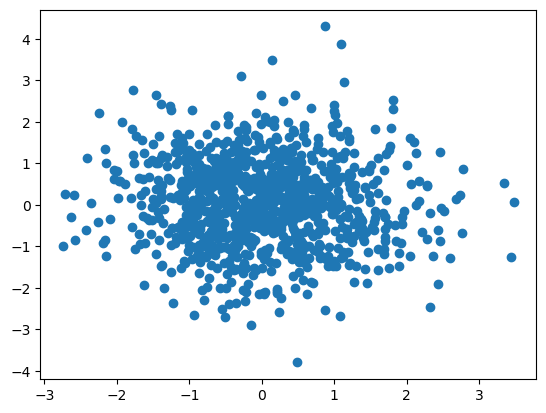

In [49]:
plt.scatter(white_data[:, 0], white_data[:, 1])

For eigenvectors and eigenvalues of a matrix $A$ it is true that 

$$A v = \lambda v$$

where $v$ is an eigenvector and $\lambda$ is a corresponding eigenvalue

In [50]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

v = eigenvectors[:, 0]
lambd = eigenvalues[0]

lhs = cov @ v 
rhs = lambd * v

print(f"LHS = {lhs}")
print(f"RHS = {rhs}")
print(np.allclose(lhs, rhs))

LHS = [3.53553391 3.53553391]
RHS = [3.53553391 3.53553391]
True


If we have white data $D$ defined as above, then we can apply a transformation $T$ consisting of rotation $R$ and scaling $S$ ($T = RS$) to get new data $D'$. It relates covariance matrix as follows $$\Sigma = TIT^{T}$$ $$\Sigma = RS(RS)^{T}$$ $$\Sigma = RSS^TR^T$$

How does it relate to eigenvalues & eigenvectors?

$$\Sigma V = V L$$ where $V$ is a matrix of eigenvectors and $L$ is a diagonal matrix of eigenvalues

$$\Sigma = V L V^{-1}$$

It is the eigendecomposition of the covariance matrix, where $R = V$ and $S = \sqrt{L}$

In [116]:
cov = np.array([[3, 2], [2, 3]])
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [52]:
eigenvalues

array([5., 1.])

In [53]:
eigenvectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [54]:
R = eigenvectors
S = np.sqrt(np.diag(eigenvalues))
print(R)
print(S)
new_cov = R @ S @ S.T @ R.T
print(new_cov)
np.allclose(new_cov, cov) # same as original one

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]
[[3. 2.]
 [2. 3.]]


True

In [55]:
U, M, V = LA.svd(cov)
M = np.sqrt(np.diag(M))

In [56]:
print(U)
print(M)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]


In [57]:
np.allclose(new_cov, cov) # same as original one

True

In [58]:
transformed_data = white_data @ S @ R.T

In [59]:
transformed_data

array([[-0.64658588, -1.92751877],
       [-0.68530148, -0.69799066],
       [ 0.17863157,  0.43195702],
       ...,
       [ 3.18181772, -0.3989743 ],
       [-0.26727566,  2.08156662],
       [ 2.68118445,  1.78701874]])

In [60]:
data = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1000)

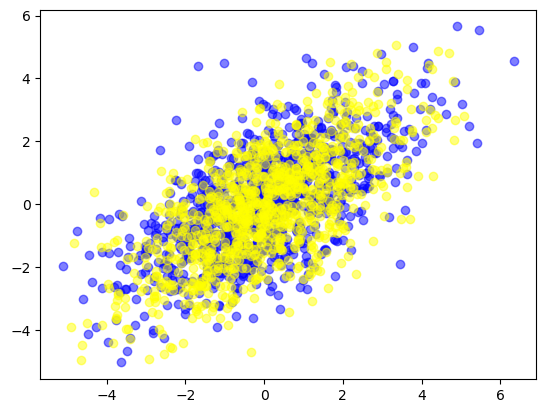

In [61]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5, color='blue')
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')

### Gaussian function

Gaussian function with mean $\mu \in R^{n}$ and covariance $\Sigma$ is given by

$$ G(x) = exp({-\frac{1}{2}(x - \mu)^T} \Sigma^{-1} (x - \mu))$$

This can be used to compute the strength that a given splat has on a given pixel

However, this only works when $\Sigma$ is positive-definite, which may not be true during gradient descent updates

In [121]:
def inverse_cov_2d(cov):
    det = cov[0, 0] * cov[1, 1] - cov[0, 1] * cov[1, 0]
    return 1 / det * np.array([[cov[1, 1], -cov[0, 1]], [-cov[1, 0], cov[0, 0]]])

In [122]:
inverse_cov_2d(cov)

array([[ 0.6, -0.4],
       [-0.4,  0.6]])

In [123]:
LA.inv(cov)

array([[ 0.6, -0.4],
       [-0.4,  0.6]])

In [125]:
def gaussian_weight_2d(x, mu, cov):
    return np.exp(-1/2 * (x - mu).T @ inverse_cov_2d(cov) @ (x - mu))

In [126]:
mean = np.array([0, 0])
cov = np.array([[3, 2], [2, 3]])
x = np.array([3, 3])

In [127]:
gaussian_weight_2d(x, mean, cov)

np.float64(0.16529888822158645)

In [128]:
x = np.linspace(-4, 4, 20)
y = np.linspace(-4, 4, 20)
X, Y = np.meshgrid(x, y)
arr = np.vstack((X.ravel(), Y.ravel())).T

How to vectorize this multiplication?

In [134]:
weights = np.array([gaussian_weight_2d(x, mean, cov) for x in arr])

Validate results

(-4.0, 4.0)

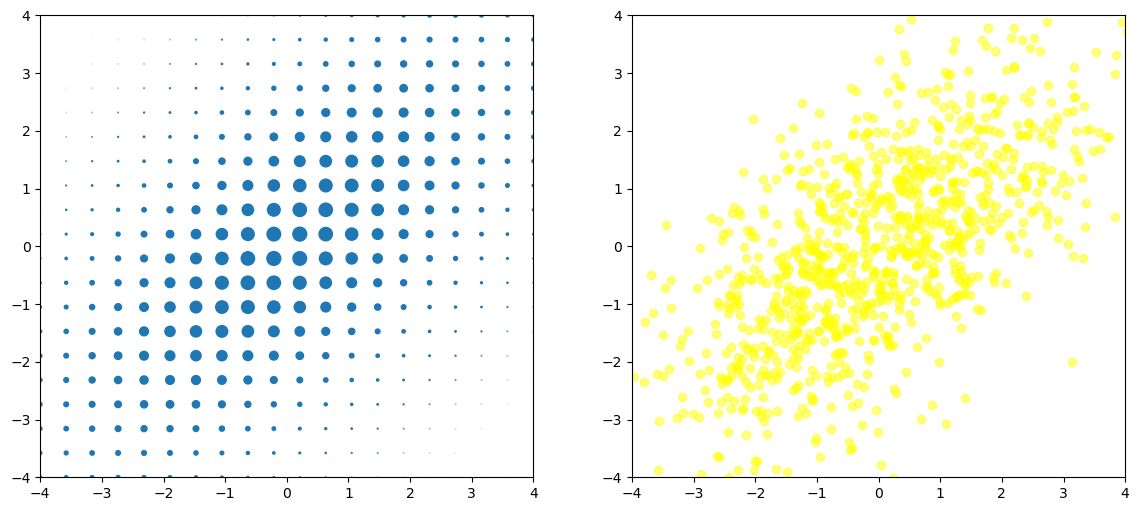

In [132]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(arr[:, 0], arr[:, 1], s=weights * 100)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')
plt.xlim(-4, 4)
plt.ylim(-4, 4)

### Projecting 3D Covariance onto 2D 

following tutorial: https://shi-yan.github.io/how_to_render_a_single_gaussian_splat/

In general, if we want to apply $V$ transformation to a covariance matrix $\Sigma$, then 

$$\Sigma' = V \Sigma V^{T}$$

In [70]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'

reconstruction = pycolmap.Reconstruction(scene_folder / '0')
camera = reconstruction.cameras[1]
img_id = 60
img = reconstruction.images[img_id]
img_name = img.name

In [71]:
width, height = camera.width, camera.height

In [72]:
extrinsic_params = get_extrinsic_params(get_camera_from_image(img))
print(extrinsic_params)

[[ 0.65883531 -0.16565849 -0.73382103  1.29975755]
 [ 0.21772808  0.97569481 -0.02478149  1.12463341]
 [ 0.72009063 -0.14344652  0.6788907   3.4804925 ]
 [ 0.          0.          0.          1.        ]]


In [73]:
viewing_transformation = extrinsic_params[:3, :3].T # LA.inv(extrinsic_params[:3, :3])
viewing_transformation

array([[ 0.65883531,  0.21772808,  0.72009063],
       [-0.16565849,  0.97569481, -0.14344652],
       [-0.73382103, -0.02478149,  0.6788907 ]])

In [74]:
cov3D = np.array([[1, 2, 3], [2, 3, 2], [1, 1, 1]])

Viewing transformation is used to transform from object space to camera coordinates

In [75]:
variance_in_camera_coordinates = viewing_transformation @ cov3D @ viewing_transformation.T
variance_in_camera_coordinates

array([[ 4.03663522,  1.87569168,  0.72820407],
       [ 2.55994973,  1.93260467, -0.37591142],
       [-1.38884404, -0.59929057, -0.96923988]])

### Perspective Projection

https://www.songho.ca/opengl/gl_projectionmatrix.html

In perspective projection, a 3D point in a truncated pyramid frustum (eye coordinates) is mapped to a cube (NDC).

<div>
<img src="images/gl_projectionmatrix01.png" width="500">
</div>

A 3D point is projected onto **near** plane in eye space (2D). The following show how point $(x_e, y_e, z_e)$ is projected to $(x_p, y_p, z_p)$ on the near space.

<div>
<img src="images/gl_projectionmatrix03.png" width="500">
<img src="images/gl_projectionmatrix04.png" width="500">
</div>

Using the ratio of similar triangles, we calculate:

$$x_p = \frac{n * x_e}{-z_e}$$
$$y_p = \frac{n * y_e}{-z_e}$$
$$z_p = -n$$

However, this transformation can't be represented by 3x3 matrix so we'll need to use it's approximation. We'll need to find Jacobian matrix 

$$ J = \begin{pmatrix}
 \frac{x_p}{x_e} & \frac{y_p}{x_e} & \frac{z_p}{x_e} \\
 \frac{x_p}{y_e} & \frac{y_p}{y_e} & \frac{z_p}{y_e} \\
 \frac{x_p}{z_e} & \frac{y_p}{z_e} & \frac{z_p}{z_e} 
 \end{pmatrix}
 $$
 
$$J = \begin{pmatrix} 
\frac{-n}{z_e} & 0 & 0 \\
0 & -\frac{n}{z_e} & 0 \\
\frac{nx_e}{z_e^{2}} & \frac{ny_e}{z_e^{2}} & 0
\end{pmatrix}$$

This matrix is used to transform 3x3 covariance matrix

In [76]:
def get_jacobian_matrix(point: np.array, znear):
    J = np.zeros((3, 3))
    J[0, 0] = -znear / point[2]
    J[1, 1] = -znear / point[2]
    J[2, 0] = point[0] / point[2] ** 2
    J[2, 1] = point[1] / point[2] ** 2
    return J 

In [77]:
homogenous_points = convert_to_homogenous(get_points_xyz(reconstruction)).T
projected_to_camera_viewpoint = (extrinsic_params @ homogenous_points).T

In [78]:
jac = get_jacobian_matrix(projected_to_camera_viewpoint[0, :3], 0.1)

In [79]:
jac

array([[-0.03228303,  0.        ,  0.        ],
       [ 0.        , -0.03228303,  0.        ],
       [ 0.15443729,  0.05212275,  0.        ]])

In [80]:
cov = np.array([[3, 1, 1], [0, 3, 0], [1, 1, 3]])

In [81]:
projected_cov = jac @ viewing_transformation @ cov @ viewing_transformation.T @ jac.T

We'll only need upper-left square

In [82]:
projected_cov[:2, :2]

array([[ 0.00442836,  0.00117936],
       [-0.00029296,  0.0028618 ]])

In [120]:
LA.det(projected_cov[:2, :2])

np.float64(1.3018560926687078e-05)

In [83]:
eigenvalues, eigenvectors = LA.eig(np.array([[2, 1], [1, 3]]))

In [84]:
eigenvalues, eigenvectors

(array([1.38196601, 3.61803399]),
 array([[-0.85065081, -0.52573111],
        [ 0.52573111, -0.85065081]]))

### Bounding box for a splat

Bounding box will be used during rasterization to decide whether a given pixel can be affected at all by a splat.

- Approach 1: compute bounding box for an ellipsoid

- Approach 2: use the largest eigenvalue to evaluate the extent of influence

In [99]:
cov_2d = np.array([[3, 2], [4, 6]])

In [107]:
def get_bounding_box(mu, cov, extent=3.0):
    eigenvalues, eigenvectors = LA.eig(cov)
    radius = extent * math.sqrt(abs(eigenvalues[-1])) # 3 standard deviations from the center
    bounding_box = np.array([
        mu[0] + radius, # x max
        mu[0] - radius, # x min
        mu[1] + radius, # y max
        mu[1] - radius]) # y min
    return bounding_box

In [108]:
get_bounding_box(np.array([0, 0]), cov_2d)

array([ 8.32550654, -8.32550654,  8.32550654, -8.32550654])

[7.70156212 1.29843788] [[-0.76164568 -0.39144501]
 [ 0.64799372 -0.9202015 ]] [[-0.39144501 -0.76164568]
 [-0.9202015   0.64799372]]
[1. 1.]


C:\Users\julia\AppData\Local\Temp\ipykernel_24636\3248433845.py:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=mean, cov=cov_2d, size=1000)


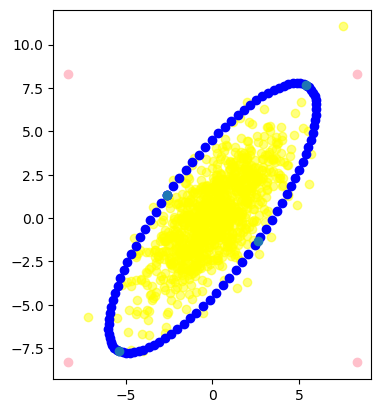

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Define the circle parameters
r = 1  # radius
theta = np.linspace(0, 2 * np.pi, 100)  # 100 points between 0 and 2pi

# Parametric equations for the circle
x = r * np.cos(theta)
y = r * np.sin(theta)

extend_factor = 3

eigenvalues, eigenvectors = LA.eig(cov_2d)
print(eigenvalues[::-1], eigenvectors, eigenvectors[:, [1, 0]])
print(np.sign(eigenvalues))
sphere_points = np.stack((x, y), axis=0).reshape(2, -1)
sphere_points = (eigenvectors.T @ (np.diag(np.sqrt(np.abs(eigenvalues))) * extend_factor) @ sphere_points).T

data = np.random.multivariate_normal(mean=mean, cov=cov_2d, size=1000)
plt.scatter(data[:, 0], data[:, 1], color='yellow', alpha=0.5)
plt.scatter(sphere_points[:, 0], -sphere_points[:, 1], color='blue')
edge_points = np.array([
    [0, 1], 
    [1, 0],
    [0, -1],
    [-1, 0]
])

R = eigenvectors
edge_points = (R.T @ np.diag(np.sqrt(eigenvalues)* extend_factor) @ edge_points.T).T

plt.scatter(edge_points[:, 0], -edge_points[:, 1])

x_max, x_min, y_max, y_min = get_bounding_box(np.array([0, 0]), cov_2d)
bounding_box = np.array([
    [x_max, y_max], [x_max, y_min], [x_min, y_max], [x_min, y_min]
])
plt.scatter(bounding_box[:, 0], bounding_box[:, 1], color='pink') # bounding box points

# Set the aspect ratio to equal to ensure the circle isn't distorted
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

In [113]:
def pixels_within_bb_ids(pixels, mu, cov, extent=3.0):
    x_max, x_min, y_max, y_min = get_bounding_box(mu, cov, extent=extent)
    ids = (pixels[:, 0] < x_max) & (pixels[:, 0] > x_min) & (pixels[:, 1] < y_max) & (pixels[:, 1] > y_min)
    return ids

In [103]:
# shit code, skip it
eigenvalues, eigenvectors = LA.eig(cov_2d)
R = eigenvectors
L = np.sqrt(np.diag(eigenvalues))
edge_points = np.array([
    [0, 1], 
    [1, 0],
    [0, -1],
    [-1, 0]
])
edge_points = edge_points @ L @ R.T
x, y = edge_points[1, 0], edge_points[1, 1]
sin_phi = y / L[0, 0]

phi = np.arcsin(sin_phi)
print(f"Angle of ellipsoid is {np.rad2deg(phi):.2f}")

tan_t1 = - L[1, 1] * np.tan(phi) / L[0, 0]
tan_t2 = L[1, 1] / (np.tan(phi) * L[0, 0])
print(f"Tan t1 {tan_t1:.2f} t2 {tan_t2:.2f}")

t1 = np.arctan(tan_t1)
t2 = np.arctan(tan_t2)
print(f"t1 {tan_t1:.2f} t2 {tan_t2:.2f}")

x1 = L[0, 0] * np.cos(t1) * np.cos(phi) - L[1, 1] * np.sin(t1) * np.sin(phi)
x2 = L[0, 0] * np.cos(t2) * np.cos(phi) - L[1, 1] * np.sin(t2) * np.sin(phi)
print(x1, x2)

y1 = L[1, 1] * np.sin(t1) * np.cos(phi) + L[0, 0] * np.cos(t1) * np.sin(phi)
y2 = L[1, 1] * np.sin(t2) * np.cos(phi) + L[0, 0] * np.cos(t2) * np.sin(phi)
print(y1, y2)

Angle of ellipsoid is 40.39
Tan t1 -2.07 t2 2.86
t1 -2.07 t2 2.86
1.9967681967764097 -1.4114661263928963
-1.582661566624196 2.238954391751267


In [91]:
sphere_points[:2]

array([[-0.86788778,  0.73838248],
       [-0.93503949,  0.57492929]])

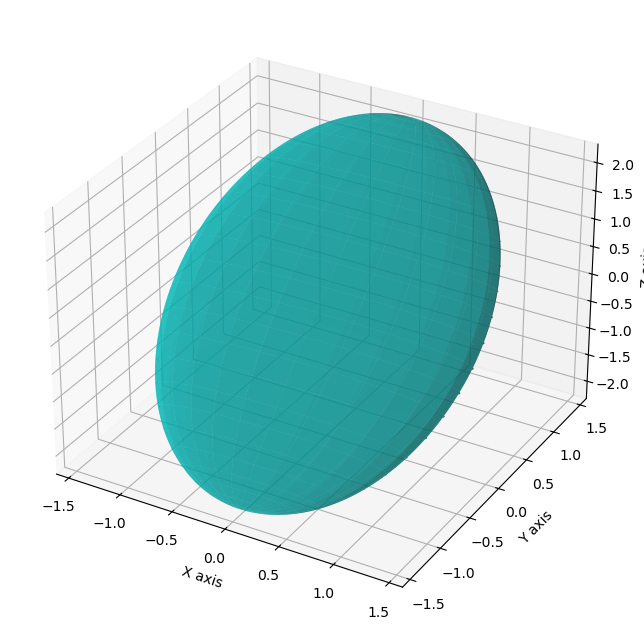

In [105]:
# Generated by chatgpt
import numpy as np
import matplotlib.pyplot as plt

cov = np.array([[2, 0, 0], [0, 2, 0], [0, 3, 5]])

# Step 2: Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Step 3: Generate a sphere
# Create a grid of points that forms a unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Stack the sphere points into a 3xN array (for matrix multiplication)
sphere_points = np.stack((x, y, z), axis=0).reshape(3, -1)

# Step 4: Transform the unit sphere into the ellipsoid using the covariance matrix
# Scale the sphere points by the eigenvalues and rotate them using the eigenvectors
ellipsoid_points = eigvecs @ np.diag(np.sqrt(eigvals)) @ sphere_points

# Reshape to 3D for plotting
x_ellipsoid = ellipsoid_points[0, :].reshape(100, 100)
y_ellipsoid = ellipsoid_points[1, :].reshape(100, 100)
z_ellipsoid = ellipsoid_points[2, :].reshape(100, 100)

# Step 5: Plot the ellipsoid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the ellipsoid
ax.plot_surface(x_ellipsoid, y_ellipsoid, z_ellipsoid, color='c', alpha=0.6, rstride=4, cstride=4, linewidth=0.5)

# Add labels and set equal aspect ratio
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()